ERROR:fiona._env:PROJ: proj_identify: /nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR:fiona._env:PROJ: proj_identify: /nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


80
DimCoord([2009-06-01 00:12:30], bounds=[[2009-06-01 00:00:00, 2009-06-01 00:25:00]], standard_name='time', calendar='gregorian', var_name='time')
DimCoord([2009-08-31 23:40:00], bounds=[[2009-08-31 23:30:00, 2009-08-31 23:50:00]], standard_name='time', calendar='gregorian', var_name='time')
getting mask
Min value is 0.0
0.0
456.4375


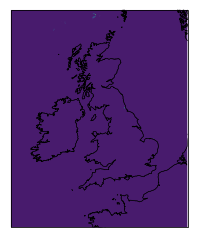

In [83]:
#!/usr/bin/env python
# coding: utf-8

# In[6]:


import iris.coord_categorisation
import iris
import numpy as np
import os
import geopandas as gpd
import sys
import matplotlib 
import numpy.ma as ma
import warnings
import iris.quickplot as qplt
import iris.plot as iplt
import cartopy.crs as ccrs
from matplotlib import colors
import glob as glob
import datetime
warnings.simplefilter(action = 'ignore', category = FutureWarning)
from iris.experimental.equalise_cubes import equalise_attributes


# In[7]:


# Set up path to root directory
root_fp = "/nfs/a319/gy17m2a/PhD/"
os.chdir(root_fp)

# Create path to files containing functions
sys.path.insert(0, '/nfs/a319/gy17m2a/PhD/Scripts/GlobalFunctions')
from Spatial_plotting_functions import *
from Spatial_geometry_functions import *

resolution = '2.2km'
trim_to_leeds = False

# # Constraint to only load JJA data
in_jja=iris.Constraint(time=lambda cell: 6 <= cell.point.month <= 8)

##################################################################
# Load necessary spatial data
##################################################################
# This is a square area surrounding Leeds
leeds_at_centre_gdf = create_leeds_at_centre_outline({'init' :'epsg:3857'})
uk_gdf = create_uk_outline({'init' :'epsg:3857'})


# ### Load data for one year

# In[8]:


year = 2009

# Create directory to store outputs in
if resolution =='1km':
    ddir = f"ProcessedData/TimeSeries/NIMROD/30mins/OriginalFormat_1km/"
    general_filename = f'datadir/NIMROD/30mins/OriginalFormat_1km/{year}/*'      
elif resolution == '2.2km':
    ddir = f"ProcessedData/TimeSeries/NIMROD/30mins/NIMROD_regridded_2.2km/"
    general_filename = f'datadir/NIMROD/30mins/NIMROD_regridded_2.2km/NearestNeighbour/{year}/*'      
elif resolution == '12km':
    ddir = f"ProcessedData/TimeSeries/NIMROD/30mins/NIMROD_regridded_12km/"    
    general_filename = f'datadir/NIMROD/30mins/NIMROD_regridded_12km/NearestNeighbour/{year}/*'      
if not os.path.isdir(ddir):
    os.makedirs(ddir)


# In[20]:


filenames =[]
# Find all files in directory which start with this string
for filename in glob.glob(general_filename):
    # print(filename)
    filenames.append(filename)
print(len(filenames))
sorted_list = sorted(filenames)

# Load the data
monthly_cubes_list = iris.load(sorted_list, in_jja)

# Get rid of any files which don't have the time dimension
is_to_delete = []
for i in range(0,len(monthly_cubes_list) ):
    if len(monthly_cubes_list[i].shape) <3:
        is_to_delete.append(i)
for i in is_to_delete:
    print(i)
    del monthly_cubes_list[i] 

for i in range(0, len(monthly_cubes_list)):
    try:
        monthly_cubes_list[i].coord('forecast_period')
        monthly_cubes_list[i].remove_coord('forecast_period')
    except:
        pass
    try:
        monthly_cubes_list[i].coord('forecast_reference_time')
        monthly_cubes_list[i].remove_coord('forecast_reference_time')
    except:
        pass           
    try:
        monthly_cubes_list[i].coord('hour')
        monthly_cubes_list[i].remove_coord('hour')
    except:
        pass   

# Try to make attributes the same
iris.util.equalise_attributes(monthly_cubes_list)   


# In[22]:


for i in range(0, len(monthly_cubes_list)):
    monthly_cubes_list[i].data = monthly_cubes_list[i].data.astype('float64')


# In[23]:


cube_jja = monthly_cubes_list.concatenate_cube()


# In[24]:


print(cube_jja.coord('time')[0])
print(cube_jja.coord('time')[-1])


# In[ ]:


# for i in range(0, len(monthly_cubes_list[:80])):
#         print(monthly_cubes_list[i].coord('time')[0])


# In[25]:


# try:
#     cube_jja = monthly_cubes_list.concatenate_cube()
# except:
#     test = len(monthly_cubes_list[0].coord('grid_longitude').points)
#     for i in range(0, len(monthly_cubes_list)):
#         if len(monthly_cubes_list[i].coord('grid_longitude').points) != test:
#             print("uhuioh")
#     cube_jja = monthly_cubes_list.concatenate_cube()


# In[ ]:


# # cube_jja = monthly_cubes_list.concatenate_cube()     
# test = len(monthly_cubes_list[0].coord('projection_y_coordinate').points)
# for i in range(0, len(monthly_cubes_list)):
#     if len(monthly_cubes_list[i].coord('projection_x_coordinate').points) != test:
#         print("uhuioh")


# ### Trim to UK

# In[26]:


cube_jja_uk = trim_to_bbox_of_region_regriddedobs(cube_jja, uk_gdf)


# ### Check plotting

# In[27]:


iplt.contourf(cube_jja[10])
plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5);


# In[ ]:


# iplt.contourf(cube_jja_uk[0])
# plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5);


# ### Get land sea mask

# In[28]:


print("getting mask")
lsm_cubes_list = iris.load("/nfs/a319/gy17m2a/PhD/datadir/lsm_land-cpm_BI_5km.nc")
lsm = lsm_cubes_list[0]
lsm_nn =lsm.regrid(cube_jja_uk,iris.analysis.Nearest())   


# ### Convert land sea mask to a cube of the same shape as our data 

# In[29]:


# Convert to shape of cube
broadcasted_lsm_data = np.broadcast_to(lsm_nn.data.data, cube_jja_uk.shape)
# Convert to integer
broadcasted_lsm_data_int = broadcasted_lsm_data.astype(int)
# Reverse the array (it is the opposite way round to the exisitng val/no val mask on the radar data)
reversed_array = ~broadcasted_lsm_data_int.astype(bool)


# In[30]:


# land_mask = np.where(lsm_nn.data > 0, True, False)
# broadcasted_lsm_data = np.broadcast_to(land_mask, cube_jja_uk.shape)
# lsm_cube = cube_jja_uk.copy(data=broadcasted_lsm_data)


# ### Mask the cube using the lsm cube

# In[31]:


masked_cube = iris.util.mask_cube(cube_jja_uk, reversed_array)


# ### Check plotting

# In[32]:


iplt.contourf(masked_cube[0])
plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5);


# ### Save to check with ncview
# Run linux ncview f'masked-cube-{year}-{resolution}.nc'

# In[34]:


ddir + f'{year}_maskedcube.nc'


# In[33]:


iris.save(masked_cube, ddir + f'{year}_maskedcube.nc')


# In[ ]:


# test =cube_jja_uk.data.flatten()
# test.shape


# In[36]:


print(f"Min value is {np.nanmin(masked_cube.data)}")


# ### Compress data (flatten and remove masked values)

# In[37]:


compressed = masked_cube.data.compressed()
compressed.shape[0]

compressed = compressed[~np.isnan(compressed)]


# ### Check length of data from flattening it before compressing (shows we have lost 60% values)

# In[ ]:


# notcompressed = masked_cube.data.flatten()
# (compressed.shape[0] / (notcompressed.shape[0] + compressed.shape[0])) *100


# ### Sense check min/max values

# In[38]:


print(np.nanmin(compressed))
print(np.nanmax(compressed))


# In[39]:


less0 = compressed[compressed <0]
more0 = compressed[compressed >0]


# ### Save to numpy array

# In[40]:


np.save(ddir + f'{year}_compressed.npy', compressed) 

